In [1]:
import cv2
import os
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from skimage.transform import resize

In [3]:
# Text processing imports - New!
from transformers import BlipProcessor, BlipForConditionalGeneration
from sentence_transformers import SentenceTransformer

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
device = "cuda" if torch.cuda.is_available() else "cpu"

2025-04-11 17:04:08.185920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744391048.382241      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744391048.441154      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CUDA available: True
GPU device: Tesla T4


In [4]:
def load_images_and_labels_from_folder(folder, normalize=True):
    print(f"🔍 Starting to load images from: {folder}")
    X = []
    y = []
    count = 0
    subfolder_counts = {}

    for root, _, files in os.walk(folder):
        if root == folder:
            continue  # Skip the root directory itself

        subfolder_name = os.path.basename(root)
        print(f"\n📂 Processing subfolder: {subfolder_name}")
        subfolder_image_count = 0

        for filename in files:
            img_path = os.path.join(root, filename)
            img = cv2.imread(img_path)
            if img is not None:
                if normalize:
                    img = img.astype('float32') / 255.0
                X.append(img)
                y.append(subfolder_name)
                count += 1
                subfolder_image_count += 1
            else:
                print(f"⚠️ Warning: Failed to load image: {img_path}")

        subfolder_counts[subfolder_name] = subfolder_image_count
        print(f"✅ Loaded {subfolder_image_count} images from '{subfolder_name}'")

    print(f"\n📊 Summary:")
    for subfolder, c in subfolder_counts.items():
        print(f"   - {subfolder}: {c} images")
    print(f"\n🎉 Total images loaded: {count}")

    return X, y


In [5]:
def extract_sift_descriptors(img, max_features=100):
    """Extract SIFT descriptors from an image."""
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros((max_features, 128), dtype=np.float32)
    if descriptors.shape[0] < max_features:
        padding = np.zeros((max_features - descriptors.shape[0], 128), dtype=np.float32)
        descriptors = np.vstack((descriptors, padding))
    else:
        descriptors = descriptors[:max_features]
    return descriptors

def get_sift_features(X, max_features=4):
    """Get SIFT features for a set of images."""
    print(f"\n🔎 Extracting SIFT descriptors ({max_features} keypoints per image)...")
    X_sift = []

    for i, img in enumerate(X):
        desc = extract_sift_descriptors(img, max_features)
        X_sift.append(desc.flatten())

        if desc is not None and np.count_nonzero(desc) > 0:
            print(f"   ✅ Image {i+1}: {desc.shape[0]} descriptors extracted")
        else:
            print(f"   ⚠️  Image {i+1}: No descriptors found")

        if (i + 1) % 50 == 0 or i == len(X) - 1:
            print(f"   → Processed {i+1}/{len(X)} images")

    X_sift = np.array(X_sift)
    print(f"\n📐 Final feature matrix shape: {X_sift.shape}")
    return X_sift

def extract_hog_features(img, resize_dim=(128, 128), pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    """Extract HOG features from an image."""
    gray = rgb2gray((img * 255).astype('uint8'))
    gray_resized = resize(gray, resize_dim, anti_aliasing=True)
    
    features = hog(gray_resized,
                   orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys',
                   feature_vector=True)
    
    return features

def get_hog_features(X, feature_length=300, resize_dim=(128, 128)):
    """Get HOG features for a set of images."""
    print(f"\n📦 Extracting HOG features...")
    X_hog = []

    for i, img in enumerate(X):
        features = extract_hog_features(img, resize_dim)
        original_len = len(features)

        # Pad or trim to match feature_length
        if original_len < feature_length:
            features = np.pad(features, (0, feature_length - original_len))
        else:
            features = features[:feature_length]

        X_hog.append(features)
        print(f"   ✅ Image {i+1}: HOG len {original_len} → Final {len(features)}")

        if (i + 1) % 50 == 0 or i == len(X) - 1:
            print(f"   → Processed {i+1}/{len(X)} images")

    X_hog = np.array(X_hog)
    print(f"\n📐 Final feature matrix shape: {X_hog.shape}")
    return X_hog

def extract_color_histogram(img):
    """Extract a 128D HSV color histogram."""
    hsv_img = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2HSV)

    bins = [64, 32, 32]  # For H, S, V
    ranges = [0, 256]

    hist_features = []
    for i, b in enumerate(bins):
        hist = cv2.calcHist([hsv_img], [i], None, [b], ranges)
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)

    return np.array(hist_features, dtype=np.float32)

def get_color_histogram_features(X):
    """Get color histogram features for a set of images."""
    print(f"\n🌈 Extracting 128D Color Histogram features...")
    X_hist = []

    for i, img in enumerate(X):
        features = extract_color_histogram(img)
        X_hist.append(features)

        print(f"   ✅ Image {i+1}: {len(features)}-D histogram extracted")

        if (i + 1) % 50 == 0 or i == len(X) - 1:
            print(f"   → Processed {i+1}/{len(X)} images")

    X_hist = np.array(X_hist)
    print(f"\n📐 Final feature matrix shape: {X_hist.shape}")
    return X_hist

def extract_canny_edges(img, resize_dim=(32, 16), threshold1=100, threshold2=200):
    """Extract Canny edge features from a single image."""
    gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, resize_dim)
    edges = cv2.Canny(resized, threshold1, threshold2)

    flat_edges = edges.flatten().astype(np.float32) / 255.0  # Normalize to [0, 1]

    if np.count_nonzero(flat_edges) > 0:
        print("   ✅ Edges detected")
    else:
        print("   ⚠️  No edges detected")

    return flat_edges  # Output will be 512D if resize_dim = (32, 16)

def get_canny_edge_features(X, resize_dim=(32, 16), threshold1=100, threshold2=200):
    """Get Canny edge features for a set of images."""
    print(f"\n🪓 Extracting {resize_dim[0]*resize_dim[1]}D Canny Edge features...")
    all_edges = []

    for i, img in enumerate(X):
        print(f"\n🖼️  Image {i+1}")
        edges = extract_canny_edges(img, resize_dim, threshold1, threshold2)
        all_edges.append(edges)

    all_edges = np.array(all_edges)
    print(f"\n✅ Final edge feature matrix shape: {all_edges.shape}")
    return all_edges

def extract_lbp_features(img, target_dim=128, P=8, R=1, method='uniform', resize_dim=(128, 128)):
    """Extract a fixed-length LBP histogram from a single image."""
    gray = rgb2gray((img * 255).astype('uint8'))
    gray_resized = resize(gray, resize_dim, anti_aliasing=True)

    lbp = local_binary_pattern(gray_resized, P, R, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # Pad or truncate to get target_dim
    if len(hist) < target_dim:
        pad = np.zeros(target_dim - len(hist))
        hist = np.concatenate([hist, pad])
    else:
        hist = hist[:target_dim]

    return hist.astype(np.float32)

def get_lbp_features(X, target_dim=128):
    """Get LBP features for a set of images."""
    print(f"\n🧵 Extracting {target_dim}D LBP features...")
    features = []

    for i, img in enumerate(X):
        feat = extract_lbp_features(img, target_dim)
        features.append(feat)

        if np.count_nonzero(feat) > 0:
            print(f"   ✅ Image {i+1}: Feature length {len(feat)}")
        else:
            print(f"   ⚠️  Image {i+1}: No LBP features found")

        if (i + 1) % 50 == 0 or i == len(X) - 1:
            print(f"   → Processed {i+1}/{len(X)} images")

    features = np.array(features)
    print(f"\n📐 Final LBP feature matrix shape: {features.shape}")
    return features

In [6]:
def setup_resnet50():
    """Setup pretrained ResNet-50 model."""
    model = models.resnet50(pretrained=True).to(device)
    # Remove final fully connected layer
    model = torch.nn.Sequential(*list(model.children())[:-1]).to(device)
    model.eval()  # Set to evaluation mode
    
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                            std=[0.229, 0.224, 0.225])   # ImageNet std
    ])
    
    return model, preprocess

def extract_resnet50_features(img, model, preprocess):
    """Extract 2048D features from ResNet-50 for a single image."""
    if isinstance(img, np.ndarray):
        img = Image.fromarray((img * 255).astype(np.uint8))
    
    input_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(input_tensor)
    
    return features.view(-1).cpu().numpy()

def get_resnet50_features(X):
    """Get ResNet-50 features for a set of images."""
    print("\n🧠 Extracting 2048D ResNet-50 features...")
    model, preprocess = setup_resnet50()
    all_features = []

    for i, img in enumerate(X):
        print(f"📷 Image {i+1}")
        feat = extract_resnet50_features(img, model, preprocess)
        all_features.append(feat)
        
        if (i + 1) % 10 == 0 or i == len(X) - 1:
            print(f"   → Processed {i+1}/{len(X)} images")

    features = np.array(all_features)
    print(f"\n✅ Final ResNet feature matrix shape: {features.shape}")
    return features


In [7]:
def preprocess_and_flatten_images(X, resize_dim=(128, 128)):
    """Preprocess and flatten images to create a baseline feature set."""
    print("\n🖼️ Preprocessing and flattening images...")
    flattened = []
    for i, img in enumerate(X):
        img_resized = resize(img, resize_dim, anti_aliasing=True)
        flat_img = img_resized.flatten()
        flattened.append(flat_img)
        
        if (i + 1) % 50 == 0 or i == len(X) - 1:
            print(f"   → Processed {i+1}/{len(X)} images")
    
    result = np.array(flattened)
    print(f"\n✅ Final flattened image shape: {result.shape}")
    return result


In [8]:
def setup_caption_model():
    """Setup BLIP image captioning model."""
    print("\n📝 Setting up BLIP image captioning model...")
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
    return processor, model

def generate_captions(X, processor, model):
    """Generate captions for images using BLIP."""
    print("\n🗣️ Generating image captions with BLIP...")
    captions = []
    
    for i, img in enumerate(X):
        # Convert normalized image back to uint8 for PIL
        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        
        # Process image and generate caption
        inputs = processor(pil_img, return_tensors="pt").to(device)
        with torch.no_grad():
            output = model.generate(**inputs, max_length=30)
            caption = processor.decode(output[0], skip_special_tokens=True)
        
        captions.append(caption)
        print(f"📷 Image {i+1}: \"{caption}\"")
        
        if (i + 1) % 10 == 0 or i == len(X) - 1:
            print(f"   → Processed {i+1}/{len(X)} images")
    
    return captions

def setup_text_embedding_model():
    """Setup SBERT model for text embeddings."""
    print("\n📚 Setting up Sentence-BERT model...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    return model

def get_text_embeddings(captions, model):
    """Get text embeddings from captions using SBERT."""
    print("\n🔤 Extracting text embeddings from captions...")
    embeddings = model.encode(captions, show_progress_bar=True)
    print(f"\n✅ Text embeddings shape: {embeddings.shape}")
    return embeddings


In [9]:
def main():
    # Replace with the actual path to your image root folder
    image_folder = "/kaggle/input/text-guided-image-clustering/kaggle_train/kaggle_train/imagenet"
    
    # 1. Load images and labels
    X, y = load_images_and_labels_from_folder(image_folder)
    
    # Print some info
    print(f"Number of images: {len(X)}")
    print(f"First 5 labels: {y[:5]}")
    
    # Display a few sample images with their labels
    for i in range(min(5, len(X))):
        plt.figure()
        plt.imshow(X[i])
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
        plt.show()
    
    # 2. Train-Validation-Test Split
    print("\n📦 Splitting data into 60% train, 20% val, 20% test...")
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=782, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=782, stratify=y_temp)
    
    print(f"📁 Train samples: {len(X_train)}")
    print(f"📁 Val samples:   {len(X_val)}")
    print(f"📁 Test samples:  {len(X_test)}")
    
    # 3. Generate Captions (NEW!)
    caption_processor, caption_model = setup_caption_model()
    
    train_captions = generate_captions(X_train, caption_processor, caption_model)
    val_captions = generate_captions(X_val, caption_processor, caption_model)
    test_captions = generate_captions(X_test, caption_processor, caption_model)
    
    # 4. Extract Text Embeddings (NEW!)
    text_model = setup_text_embedding_model()
    
    X_train_text = get_text_embeddings(train_captions, text_model)
    X_val_text = get_text_embeddings(val_captions, text_model)
    X_test_text = get_text_embeddings(test_captions, text_model)
    
    # 5. Extract Image Features
    print("\n🧱 Extracting image features...")
    
    # Simple baseline features
    X_train_flat = preprocess_and_flatten_images(X_train)
    X_val_flat = preprocess_and_flatten_images(X_val)
    X_test_flat = preprocess_and_flatten_images(X_test)
    
    # SIFT features
    X_train_sift = get_sift_features(X_train, max_features=4)
    X_val_sift = get_sift_features(X_val, max_features=4)
    X_test_sift = get_sift_features(X_test, max_features=4)
    
    # # HOG features
    # X_train_hog = get_hog_features(X_train, feature_length=512)
    # X_val_hog = get_hog_features(X_val, feature_length=512)
    # X_test_hog = get_hog_features(X_test, feature_length=512)
    
    # # Color histogram features
    # X_train_hist = get_color_histogram_features(X_train)
    # X_val_hist = get_color_histogram_features(X_val)
    # X_test_hist = get_color_histogram_features(X_test)
    
    # # Canny edge features
    # X_train_canny = get_canny_edge_features(X_train)
    # X_val_canny = get_canny_edge_features(X_val)
    # X_test_canny = get_canny_edge_features(X_test)
    
    # # LBP features
    # X_train_lbp = get_lbp_features(X_train, 512)
    # X_val_lbp = get_lbp_features(X_val, 512)
    # X_test_lbp = get_lbp_features(X_test, 512)
    
    # # ResNet-50 features
    # X_train_resnet = get_resnet50_features(X_train)
    # X_val_resnet = get_resnet50_features(X_val)
    # X_test_resnet = get_resnet50_features(X_test)
    
    # 6. Combine All Features (now including text embeddings)
    # print("\n🔗 Combining all features...")
    
    # def combine_features(sift, hog, hist, canny, lbp, resnet, text):
    #     """Combine all features including text embeddings."""
    #     features_list = [sift, hog, hist, canny, lbp, resnet, text]
    #     return np.concatenate(features_list, axis=1)

    
    # X_train_combined = combine_features(
    #     X_train_sift, X_train_hog, X_train_hist, X_train_canny, 
    #     X_train_lbp, X_train_resnet, X_train_text
    # )
    
    # X_val_combined = combine_features(
    #     X_val_sift, X_val_hog, X_val_hist, X_val_canny, 
    #     X_val_lbp, X_val_resnet, X_val_text
    # )
    
    # X_test_combined = combine_features(
    #     X_test_sift, X_test_hog, X_test_hist, X_test_canny, 
    #     X_test_lbp, X_test_resnet, X_test_text
    # )
    
    # print(f"✅ Combined shape (train): {X_train_combined.shape}")
    # print(f"✅ Combined shape (val):   {X_val_combined.shape}")
    # print(f"✅ Combined shape (test):  {X_test_combined.shape}")
    
    # 7. Normalize features
    print("\n📏 Normalizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sift)
    X_val_scaled = scaler.transform(X_val_sift)
    X_test_scaled = scaler.transform(X_test_sift)
    
    # 8. K-Means Clustering (without PCA)
    print("\n🌀 Running K-Means clustering...")
    n_clusters = len(np.unique(y))
    kmeans = KMeans(n_clusters=n_clusters, random_state=782, n_init=10)
    kmeans.fit(X_train_scaled)
    
    train_preds_kmeans = kmeans.predict(X_train_scaled)
    val_preds_kmeans = kmeans.predict(X_val_scaled)
    test_preds_kmeans = kmeans.predict(X_test_scaled)
    
    print("✅ K-Means clustering complete.")
    
    # 9. Agglomerative Clustering
    print("\n🌳 Running Agglomerative Clustering...")
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    
    train_preds_agglo = agglo.fit_predict(X_train_scaled)
    val_preds_agglo = agglo.fit_predict(X_val_scaled)
    test_preds_agglo = agglo.fit_predict(X_test_scaled)
    
    print("✅ Agglomerative clustering complete.")
    
    # 10. Evaluation
    print("\n📈 Evaluating clustering using Adjusted Rand Index (ARI)...")
    
    def print_ari(name, y_true, preds):
        print(f"🔍 {name} ARI (Train): {adjusted_rand_score(y_true, preds[0]):.4f}")
        print(f"🔍 {name} ARI (Val):   {adjusted_rand_score(y_val, preds[1]):.4f}")
        print(f"🔍 {name} ARI (Test):  {adjusted_rand_score(y_test, preds[2]):.4f}")
    
    print_ari("K-Means", y_train, (train_preds_kmeans, val_preds_kmeans, test_preds_kmeans))
    print_ari("Agglomerative", y_train, (train_preds_agglo, val_preds_agglo, test_preds_agglo))
    
    # 11. Visualization using t-SNE (on train set)
    print("\n🎨 Running t-SNE for visualization (on train set)...")
    tsne = TSNE(n_components=2, random_state=782, perplexity=30)
    X_train_tsne = tsne.fit_transform(X_train_scaled)
    
    # Convert string labels to integers for coloring
    le = LabelEncoder()
    y_train_numeric = le.fit_transform(y_train)
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    
    # Plot ground truth
    plt.subplot(1, 2, 1)
    plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_numeric, cmap='tab10', s=10, alpha=0.7)
    plt.title("Ground Truth Labels")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    
    # Plot K-means clusters
    plt.subplot(1, 2, 2)
    plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=train_preds_kmeans, cmap='tab10', s=10, alpha=0.7)
    plt.title("K-Means Clusters")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    
    plt.tight_layout()
    plt.savefig("tsne_visualization.png")
    plt.show()
    
    # 12. Save model and results
    print("\n💾 Saving models and results...")
    import pickle
    
    # Save models (no PCA model is saved now)
    with open('kmeans_model.pkl', 'wb') as f:
        pickle.dump(kmeans, f)
    
    with open('scaler_model.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    print("✅ Models saved successfully!")
    
    # 13. Analyze clusters and their captions
    print("\n📊 Analyzing clusters and their captions...")
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(train_preds_kmeans == cluster_id)[0]
        cluster_captions = [train_captions[i] for i in cluster_indices[:5]]  # Get first 5 captions
        cluster_labels = [y_train[i] for i in cluster_indices[:5]]  # Get first 5 true labels
        
        print(f"\nCluster {cluster_id}:")
        print(f"  - Size: {len(cluster_indices)} images")
        print(f"  - Sample True Labels: {cluster_labels}")
        print(f"  - Sample Captions: {cluster_captions}")


🔍 Starting to load images from: /kaggle/input/text-guided-image-clustering/kaggle_train/kaggle_train/imagenet

📂 Processing subfolder: n07753592
✅ Loaded 500 images from 'n07753592'

📂 Processing subfolder: n02730930
✅ Loaded 500 images from 'n02730930'

📂 Processing subfolder: n09332890
✅ Loaded 500 images from 'n09332890'

📂 Processing subfolder: n02058221
✅ Loaded 500 images from 'n02058221'

📂 Processing subfolder: n04265275
✅ Loaded 500 images from 'n04265275'

📂 Processing subfolder: n04487081
✅ Loaded 500 images from 'n04487081'

📂 Processing subfolder: n07873807
✅ Loaded 500 images from 'n07873807'

📂 Processing subfolder: n03649909
✅ Loaded 500 images from 'n03649909'

📂 Processing subfolder: n02666196
✅ Loaded 500 images from 'n02666196'

📂 Processing subfolder: n01768244
✅ Loaded 500 images from 'n01768244'

📂 Processing subfolder: n02132136
✅ Loaded 500 images from 'n02132136'

📂 Processing subfolder: n02099601
✅ Loaded 500 images from 'n02099601'

📂 Processing subfolder: n

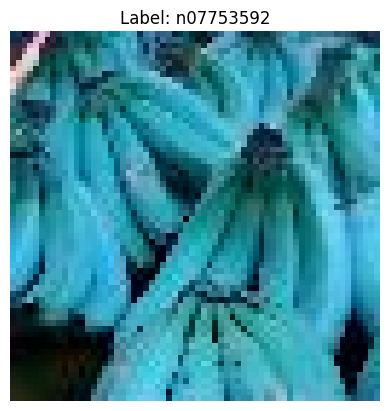

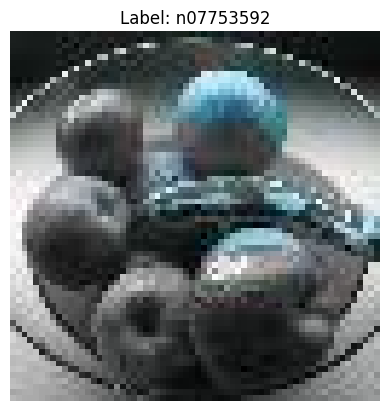

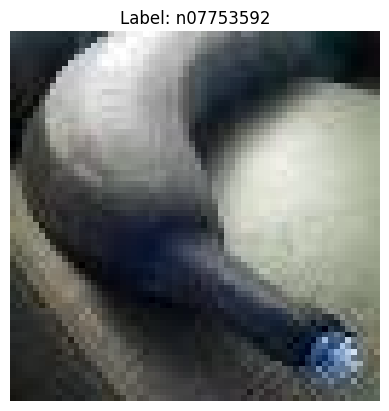

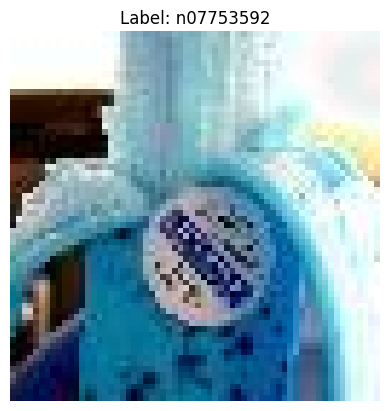

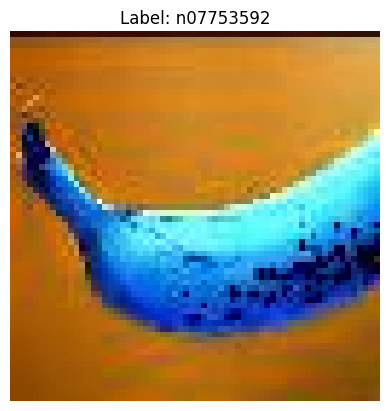

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



📦 Splitting data into 60% train, 20% val, 20% test...
📁 Train samples: 9000
📁 Val samples:   3000
📁 Test samples:  3000

📝 Setting up BLIP image captioning model...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]


🗣️ Generating image captions with BLIP...
📷 Image 1: "a long line of white pickets on a road"
📷 Image 2: "a blue bowl with a white and blue design"
📷 Image 3: "a bunch of flowers on the ground"
📷 Image 4: "a painting of a woman in a blue dress"
📷 Image 5: "a man in a white shirt is flying through the air"
📷 Image 6: "a blue smiley face with a black nose"
📷 Image 7: "a painting of a mountain with trees and a sky"
📷 Image 8: "a car is driving through the fog"
📷 Image 9: "a street with a bunch of cars parked on it"
📷 Image 10: "a small black and white animal on the ground"
   → Processed 10/9000 images
📷 Image 11: "a bowl of blue and white food"
📷 Image 12: "a blue truck parked in a parking lot"
📷 Image 13: "a dog is running on the beach"
📷 Image 14: "a large white tower"
📷 Image 15: "a group of people are playing on a green field"
📷 Image 16: "a group of people are playing in the grass"
📷 Image 17: "a group of people walking down a street"
📷 Image 18: "a blue elephant is walking through

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


🔤 Extracting text embeddings from captions...


Batches:   0%|          | 0/282 [00:00<?, ?it/s]


✅ Text embeddings shape: (9000, 384)

🔤 Extracting text embeddings from captions...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]


✅ Text embeddings shape: (3000, 384)

🔤 Extracting text embeddings from captions...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]


✅ Text embeddings shape: (3000, 384)

🧱 Extracting image features...

🖼️ Preprocessing and flattening images...
   → Processed 50/9000 images
   → Processed 100/9000 images
   → Processed 150/9000 images
   → Processed 200/9000 images
   → Processed 250/9000 images
   → Processed 300/9000 images
   → Processed 350/9000 images
   → Processed 400/9000 images
   → Processed 450/9000 images
   → Processed 500/9000 images
   → Processed 550/9000 images
   → Processed 600/9000 images
   → Processed 650/9000 images
   → Processed 700/9000 images
   → Processed 750/9000 images
   → Processed 800/9000 images
   → Processed 850/9000 images
   → Processed 900/9000 images
   → Processed 950/9000 images
   → Processed 1000/9000 images
   → Processed 1050/9000 images
   → Processed 1100/9000 images
   → Processed 1150/9000 images
   → Processed 1200/9000 images
   → Processed 1250/9000 images
   → Processed 1300/9000 images
   → Processed 1350/9000 images
   → Processed 1400/9000 images
   → Proces

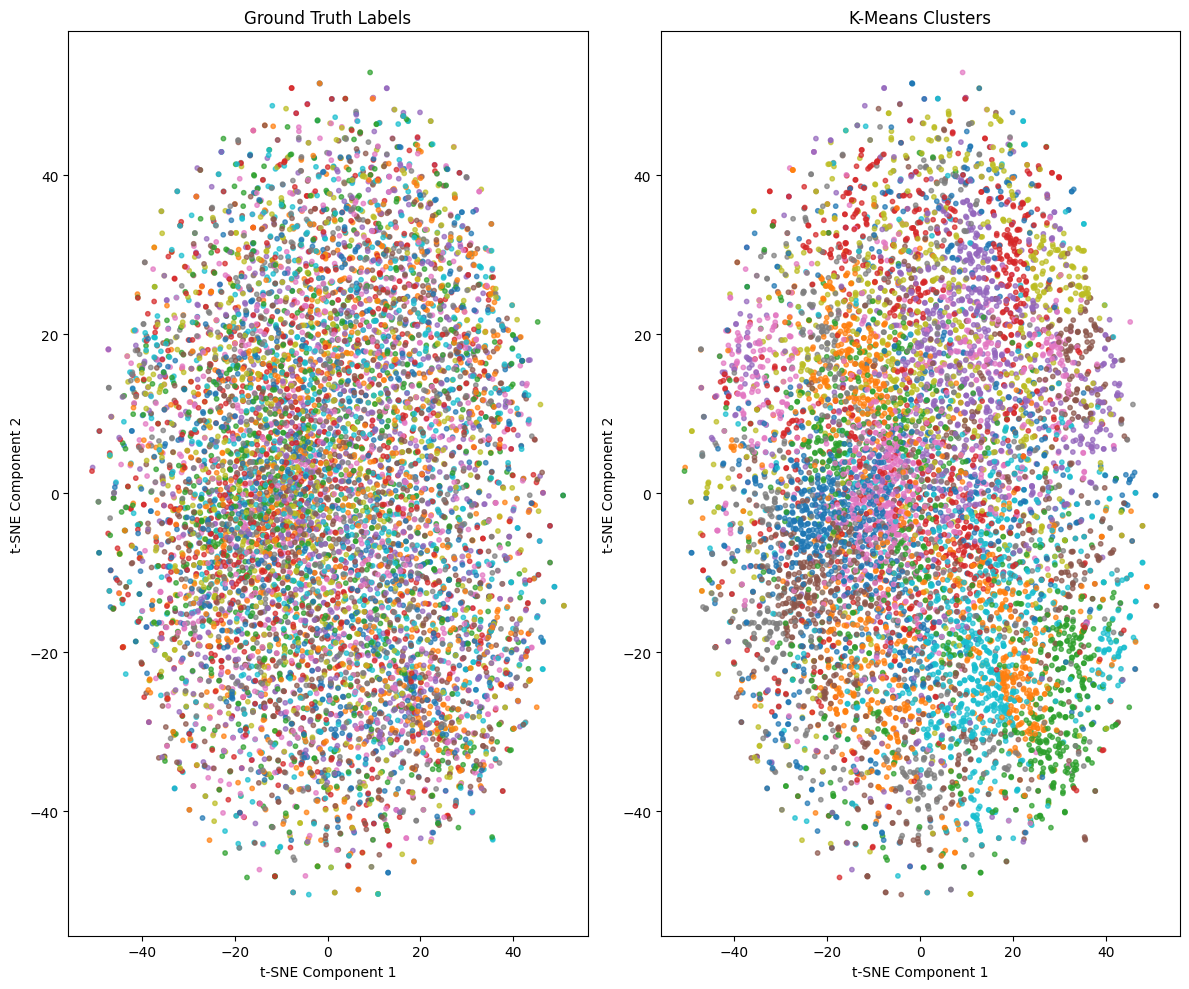


💾 Saving models and results...
✅ Models saved successfully!

📊 Analyzing clusters and their captions...

Cluster 0:
  - Size: 318 images
  - Sample True Labels: ['n02074367', 'n02666196', 'n02106662', 'n03447447', 'n04456115']
  - Sample Captions: ['a polar bear is swimming in the water', 'a bed with a blue and white checkered pattern', 'a dog running on a field with a ball', 'a blur of a person riding a motorcycle', 'a man in a white shirt']

Cluster 1:
  - Size: 338 images
  - Sample True Labels: ['n02730930', 'n09332890', 'n02504458', 'n02106662', 'n02730930']
  - Sample Captions: ['a black and white bag with a black handle', 'a tree with a lot of leaves', 'a large elephant standing in the snow', 'a moose standing in the snow with a blue sky background', 'a painting of a man in a suit']

Cluster 2:
  - Size: 337 images
  - Sample True Labels: ['n07873807', 'n09332890', 'n04067472', 'n03447447', 'n02666196']
  - Sample Captions: ['a blue bowl with a white and blue design', 'a group 

In [10]:
if __name__ == "__main__":
    main()